In [1]:
#Importowanie bibliotek
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from pylab import rcParams
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.layers import Input,Dense, Flatten, MaxPooling2D,Conv2D, BatchNormalization,AveragePooling2D,ZeroPadding2D,LeakyReLU,Add,Activation,Dropout
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import img_to_array
%matplotlib inline
rcParams['figure.figsize']=22,10

In [2]:
#Inicjalizacja akceleratora GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
#Wczytanie pliku csv
df=pd.read_csv('C:/Users/komej/Desktop/birds recognition/v2/Bird_Species.csv')

In [4]:
df.head()

,filepaths,labels,data set
0,train/AFRICAN CROWNED CRANE/001.jpg,AFRICAN CROWNED CRANE,train
1,train/AFRICAN CROWNED CRANE/002.jpg,AFRICAN CROWNED CRANE,train
2,train/AFRICAN CROWNED CRANE/003.jpg,AFRICAN CROWNED CRANE,train
3,train/AFRICAN CROWNED CRANE/004.jpg,AFRICAN CROWNED CRANE,train
4,train/AFRICAN CROWNED CRANE/005.jpg,AFRICAN CROWNED CRANE,train


In [5]:
Sieć użyta do tego celu to EfficientNetB0 przetrenowana na milionach zdjęć, co znacząco ułatwia trenowanie i zwiększa precyzję sieci.

SyntaxError: invalid syntax (<ipython-input-5-a58813bd9fc7>, line 1)

In [7]:
effnet=EfficientNetB0(include_top=False,weights='imagenet', input_shape=(224,224,3))
#for layers in effnet.layers[1:120]:
effnet.trainable=False
    
inp=effnet.output
x=Flatten()(inp)
x=Dense(512,activation='relu')(x)
x=Dropout(0.1)(x)
x=Dense(310,activation='softmax')(x)

model=Model(effnet.input,x)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                              

In [9]:
opt=Adam(learning_rate=0.00001)
#opt=SGD(learning_rate=0.00001)

In [10]:
loss=tf.keras.losses.SparseCategoricalCrossentropy()

In [11]:
model.compile(loss=loss,optimizer=opt,metrics=['accuracy'])

In [12]:
#Funkcja oparta na generatorze, której zadaniem jest wczytanie do pamięci zadaną ilość danych(zdjęć) do trenowania sieci.
def batch_gen(batch_size,label_csv):
    while(1):
        half_path='C:/Users/komej/Desktop/birds recognition/v2/'
        #Wczytanie pliku csv który zawiera ściężkę do pliku i etykiety.
        df=pd.read_csv(label_csv)
        df['labels']=pd.factorize(df['labels'])[0]
        batches=df.sample(n=batch_size)
        #print(batches['labels'])
        files=batches['filepaths']
        arr=[]
        for i in files:
            arr.append(i)
        y=batches['labels'].values
        y=y.astype('int64')
        org_images=[]
        for img in arr:
            img_train=cv2.imread(half_path+img,cv2.IMREAD_UNCHANGED)
            img_train=cv2.resize(img_train,(224,224))
            org_images.append(img_train)
        org_images=np.array(org_images)
        org_images=org_images.astype('float32')/255
        
        yield(org_images,y)

In [103]:
#Funckja do stopniowego odmrażania warstw w celu trenowania poszczególnych warstw.
def unfreeze_model(model):
    for layer in model.layers[-90:]:
        #if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
    model.compile(loss=loss,optimizer=opt,metrics=['accuracy'])

unfreeze_model(model)

(224, 224, 3)


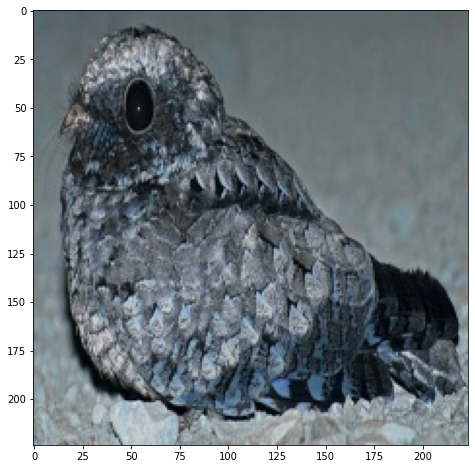

In [98]:
img=imgs[0]
print(img.shape)
#img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
#Pętla treningowa
batch_size=16
epochs=2000
epoch_l,accuracy_l=[],[]
bat=batch_gen(batch_size,'C:/Users/komej/Desktop/birds recognition/v2/Bird_Species.csv')
for e in range(1,epochs+1):
    imgs,y=next(bat)
    loss=model.train_on_batch(imgs,y)
    epoch_l.append(e)
    accuracy_l.append(loss[1])
    
    print('Epoch:',e)
    print('Main loss:',loss[0],'Accuracy',loss[1])

Epoch: 1
Main loss: 5.741253852844238 Accuracy 0.0
Epoch: 2
Main loss: 5.733933448791504 Accuracy 0.0
Epoch: 3
Main loss: 5.731265544891357 Accuracy 0.0
Epoch: 4
Main loss: 5.733616828918457 Accuracy 0.0
Epoch: 5
Main loss: 5.7367377281188965 Accuracy 0.0
Epoch: 6
Main loss: 5.735012531280518 Accuracy 0.0
Epoch: 7
Main loss: 5.735376834869385 Accuracy 0.0
Epoch: 8
Main loss: 5.747936248779297 Accuracy 0.0
Epoch: 9
Main loss: 5.739212512969971 Accuracy 0.0
Epoch: 10
Main loss: 5.737056732177734 Accuracy 0.0
Epoch: 11
Main loss: 5.731385707855225 Accuracy 0.0
Epoch: 12
Main loss: 5.735835075378418 Accuracy 0.0
Epoch: 13
Main loss: 5.732846260070801 Accuracy 0.0
Epoch: 14
Main loss: 5.729377269744873 Accuracy 0.0
Epoch: 15
Main loss: 5.731300354003906 Accuracy 0.0
Epoch: 16
Main loss: 5.738179683685303 Accuracy 0.0
Epoch: 17
Main loss: 5.736886978149414 Accuracy 0.0
Epoch: 18
Main loss: 5.734457969665527 Accuracy 0.0
Epoch: 19
Main loss: 5.746642112731934 Accuracy 0.0
Epoch: 20
Main loss:

Epoch: 159
Main loss: 5.7403764724731445 Accuracy 0.0
Epoch: 160
Main loss: 5.739282131195068 Accuracy 0.0
Epoch: 161
Main loss: 5.743452072143555 Accuracy 0.0
Epoch: 162
Main loss: 5.730668067932129 Accuracy 0.0
Epoch: 163
Main loss: 5.730545997619629 Accuracy 0.0
Epoch: 164
Main loss: 5.7360124588012695 Accuracy 0.0
Epoch: 165
Main loss: 5.734882831573486 Accuracy 0.0
Epoch: 166
Main loss: 5.742511749267578 Accuracy 0.0
Epoch: 167
Main loss: 5.736658573150635 Accuracy 0.0
Epoch: 168
Main loss: 5.73787260055542 Accuracy 0.0
Epoch: 169
Main loss: 5.735088348388672 Accuracy 0.0
Epoch: 170
Main loss: 5.737170219421387 Accuracy 0.0
Epoch: 171
Main loss: 5.735958576202393 Accuracy 0.0
Epoch: 172
Main loss: 5.73710298538208 Accuracy 0.0
Epoch: 173
Main loss: 5.739459037780762 Accuracy 0.0
Epoch: 174
Main loss: 5.736154556274414 Accuracy 0.0
Epoch: 175
Main loss: 5.73624324798584 Accuracy 0.0
Epoch: 176
Main loss: 5.735957145690918 Accuracy 0.0
Epoch: 177
Main loss: 5.736626625061035 Accurac

Epoch: 313
Main loss: 5.736936092376709 Accuracy 0.0
Epoch: 314
Main loss: 5.73631477355957 Accuracy 0.0
Epoch: 315
Main loss: 5.736661911010742 Accuracy 0.0
Epoch: 316
Main loss: 5.736544132232666 Accuracy 0.0
Epoch: 317
Main loss: 5.7364277839660645 Accuracy 0.0
Epoch: 318
Main loss: 5.736441135406494 Accuracy 0.0
Epoch: 319
Main loss: 5.736662864685059 Accuracy 0.0
Epoch: 320
Main loss: 5.73663330078125 Accuracy 0.0
Epoch: 321
Main loss: 5.736527442932129 Accuracy 0.0
Epoch: 322
Main loss: 5.736307144165039 Accuracy 0.0
Epoch: 323
Main loss: 5.73644495010376 Accuracy 0.0
Epoch: 324
Main loss: 5.73671817779541 Accuracy 0.0
Epoch: 325
Main loss: 5.736726760864258 Accuracy 0.0
Epoch: 326
Main loss: 5.736455917358398 Accuracy 0.0
Epoch: 327
Main loss: 5.736588001251221 Accuracy 0.0
Epoch: 328
Main loss: 5.736405372619629 Accuracy 0.0
Epoch: 329
Main loss: 5.737378120422363 Accuracy 0.0
Epoch: 330
Main loss: 5.736632823944092 Accuracy 0.0
Epoch: 331
Main loss: 5.736355781555176 Accuracy 

Epoch: 469
Main loss: 5.736080169677734 Accuracy 0.0
Epoch: 470
Main loss: 5.736237525939941 Accuracy 0.0
Epoch: 471
Main loss: 5.7365946769714355 Accuracy 0.0
Epoch: 472
Main loss: 5.7364373207092285 Accuracy 0.0
Epoch: 473
Main loss: 5.736517906188965 Accuracy 0.0
Epoch: 474
Main loss: 5.736456394195557 Accuracy 0.0
Epoch: 475
Main loss: 5.736632823944092 Accuracy 0.0625
Epoch: 476
Main loss: 5.736257553100586 Accuracy 0.0
Epoch: 477
Main loss: 5.736698150634766 Accuracy 0.0
Epoch: 478
Main loss: 5.736636161804199 Accuracy 0.0
Epoch: 479
Main loss: 5.736619472503662 Accuracy 0.0
Epoch: 480
Main loss: 5.736467361450195 Accuracy 0.0
Epoch: 481
Main loss: 5.7364630699157715 Accuracy 0.0
Epoch: 482
Main loss: 5.736617088317871 Accuracy 0.0
Epoch: 483
Main loss: 5.7362565994262695 Accuracy 0.0625
Epoch: 484
Main loss: 5.736391067504883 Accuracy 0.0
Epoch: 485
Main loss: 5.736384868621826 Accuracy 0.0
Epoch: 486
Main loss: 5.73632287979126 Accuracy 0.0625
Epoch: 487
Main loss: 5.7362728118

Epoch: 623
Main loss: 5.736311912536621 Accuracy 0.0
Epoch: 624
Main loss: 5.736571311950684 Accuracy 0.0
Epoch: 625
Main loss: 5.7365312576293945 Accuracy 0.0
Epoch: 626
Main loss: 5.736763954162598 Accuracy 0.0
Epoch: 627
Main loss: 5.736119270324707 Accuracy 0.0
Epoch: 628
Main loss: 5.736654281616211 Accuracy 0.0
Epoch: 629
Main loss: 5.736583232879639 Accuracy 0.0
Epoch: 630
Main loss: 5.736308574676514 Accuracy 0.0
Epoch: 631
Main loss: 5.736340522766113 Accuracy 0.0
Epoch: 632
Main loss: 5.736307144165039 Accuracy 0.0
Epoch: 633
Main loss: 5.736637115478516 Accuracy 0.0
Epoch: 634
Main loss: 5.736178398132324 Accuracy 0.0
Epoch: 635
Main loss: 5.736568450927734 Accuracy 0.0
Epoch: 636
Main loss: 5.736406326293945 Accuracy 0.0
Epoch: 637
Main loss: 5.7367777824401855 Accuracy 0.0
Epoch: 638
Main loss: 5.734392166137695 Accuracy 0.0
Epoch: 639
Main loss: 5.736385345458984 Accuracy 0.0
Epoch: 640
Main loss: 5.736217975616455 Accuracy 0.0625
Epoch: 641
Main loss: 5.735894680023193 A

Epoch: 777
Main loss: 5.736169815063477 Accuracy 0.0
Epoch: 778
Main loss: 5.736545085906982 Accuracy 0.0
Epoch: 779
Main loss: 5.736587047576904 Accuracy 0.0
Epoch: 780
Main loss: 5.736421585083008 Accuracy 0.0
Epoch: 781
Main loss: 5.7365827560424805 Accuracy 0.0
Epoch: 782
Main loss: 5.736365795135498 Accuracy 0.0
Epoch: 783
Main loss: 5.736627578735352 Accuracy 0.0
Epoch: 784
Main loss: 5.736523151397705 Accuracy 0.0
Epoch: 785
Main loss: 5.734027862548828 Accuracy 0.0
Epoch: 786
Main loss: 5.736135005950928 Accuracy 0.0
Epoch: 787
Main loss: 5.736695766448975 Accuracy 0.0
Epoch: 788
Main loss: 5.736372947692871 Accuracy 0.0
Epoch: 789
Main loss: 5.736318588256836 Accuracy 0.0
Epoch: 790
Main loss: 5.736849784851074 Accuracy 0.0
Epoch: 791
Main loss: 5.736610412597656 Accuracy 0.0
Epoch: 792
Main loss: 5.736212730407715 Accuracy 0.0
Epoch: 793
Main loss: 5.736202239990234 Accuracy 0.0
Epoch: 794
Main loss: 5.736373424530029 Accuracy 0.0
Epoch: 795
Main loss: 5.737308502197266 Accur

Epoch: 931
Main loss: 5.736853122711182 Accuracy 0.0
Epoch: 932
Main loss: 5.736533164978027 Accuracy 0.0
Epoch: 933
Main loss: 5.736485481262207 Accuracy 0.0
Epoch: 934
Main loss: 5.736573219299316 Accuracy 0.0
Epoch: 935
Main loss: 5.736224174499512 Accuracy 0.0
Epoch: 936
Main loss: 5.736476898193359 Accuracy 0.0
Epoch: 937
Main loss: 5.736964225769043 Accuracy 0.0
Epoch: 938
Main loss: 5.736368179321289 Accuracy 0.0
Epoch: 939
Main loss: 5.736446857452393 Accuracy 0.0
Epoch: 940
Main loss: 5.736449241638184 Accuracy 0.0
Epoch: 941
Main loss: 5.736057281494141 Accuracy 0.0625
Epoch: 942
Main loss: 5.736361503601074 Accuracy 0.0
Epoch: 943
Main loss: 5.736297607421875 Accuracy 0.0
Epoch: 944
Main loss: 5.736296653747559 Accuracy 0.0
Epoch: 945
Main loss: 5.736230850219727 Accuracy 0.0
Epoch: 946
Main loss: 5.736261367797852 Accuracy 0.0
Epoch: 947
Main loss: 5.736401081085205 Accuracy 0.0
Epoch: 948
Main loss: 5.736345291137695 Accuracy 0.0
Epoch: 949
Main loss: 5.736321926116943 Acc

Epoch: 1085
Main loss: 5.7361531257629395 Accuracy 0.0625
Epoch: 1086
Main loss: 5.736942768096924 Accuracy 0.0
Epoch: 1087
Main loss: 5.73628568649292 Accuracy 0.0
Epoch: 1088
Main loss: 5.736279487609863 Accuracy 0.0
Epoch: 1089
Main loss: 5.736822605133057 Accuracy 0.0
Epoch: 1090
Main loss: 5.736318588256836 Accuracy 0.0625
Epoch: 1091
Main loss: 5.7362236976623535 Accuracy 0.0
Epoch: 1092
Main loss: 5.736420631408691 Accuracy 0.0
Epoch: 1093
Main loss: 5.736689567565918 Accuracy 0.0
Epoch: 1094
Main loss: 5.736144065856934 Accuracy 0.0
Epoch: 1095
Main loss: 5.736433029174805 Accuracy 0.0
Epoch: 1096
Main loss: 5.736545085906982 Accuracy 0.0
Epoch: 1097
Main loss: 5.736265182495117 Accuracy 0.0
Epoch: 1098
Main loss: 5.736691474914551 Accuracy 0.0
Epoch: 1099
Main loss: 5.73671293258667 Accuracy 0.0
Epoch: 1100
Main loss: 5.736540794372559 Accuracy 0.0
Epoch: 1101
Main loss: 5.735937118530273 Accuracy 0.0625
Epoch: 1102
Main loss: 5.736387729644775 Accuracy 0.0
Epoch: 1103
Main lo

Epoch: 1237
Main loss: 5.7362565994262695 Accuracy 0.0
Epoch: 1238
Main loss: 5.736527442932129 Accuracy 0.0
Epoch: 1239
Main loss: 5.736117362976074 Accuracy 0.0
Epoch: 1240
Main loss: 5.736420631408691 Accuracy 0.0
Epoch: 1241
Main loss: 5.736652851104736 Accuracy 0.0
Epoch: 1242
Main loss: 5.736556053161621 Accuracy 0.0
Epoch: 1243
Main loss: 5.736156940460205 Accuracy 0.0
Epoch: 1244
Main loss: 5.736705780029297 Accuracy 0.0
Epoch: 1245
Main loss: 5.736504077911377 Accuracy 0.0
Epoch: 1246
Main loss: 5.736700534820557 Accuracy 0.0
Epoch: 1247
Main loss: 5.736262798309326 Accuracy 0.0
Epoch: 1248
Main loss: 5.736928462982178 Accuracy 0.0
Epoch: 1249
Main loss: 5.736671447753906 Accuracy 0.0
Epoch: 1250
Main loss: 5.736721515655518 Accuracy 0.0
Epoch: 1251
Main loss: 5.736260414123535 Accuracy 0.0
Epoch: 1252
Main loss: 5.736534118652344 Accuracy 0.0
Epoch: 1253
Main loss: 5.736530303955078 Accuracy 0.0
Epoch: 1254
Main loss: 5.736270904541016 Accuracy 0.0
Epoch: 1255
Main loss: 5.73

Epoch: 1389
Main loss: 5.736668109893799 Accuracy 0.0
Epoch: 1390
Main loss: 5.736677169799805 Accuracy 0.0
Epoch: 1391
Main loss: 5.736382484436035 Accuracy 0.0
Epoch: 1392
Main loss: 5.736584663391113 Accuracy 0.0
Epoch: 1393
Main loss: 5.736735820770264 Accuracy 0.0
Epoch: 1394
Main loss: 5.7364501953125 Accuracy 0.0
Epoch: 1395
Main loss: 5.736696243286133 Accuracy 0.0
Epoch: 1396
Main loss: 5.736812591552734 Accuracy 0.0
Epoch: 1397
Main loss: 5.736442565917969 Accuracy 0.0
Epoch: 1398
Main loss: 5.73682165145874 Accuracy 0.0
Epoch: 1399
Main loss: 5.736319541931152 Accuracy 0.0625
Epoch: 1400
Main loss: 5.736063003540039 Accuracy 0.0
Epoch: 1401
Main loss: 5.736582279205322 Accuracy 0.0
Epoch: 1402
Main loss: 5.736590385437012 Accuracy 0.0
Epoch: 1403
Main loss: 5.736571788787842 Accuracy 0.0625
Epoch: 1404
Main loss: 5.736087322235107 Accuracy 0.0
Epoch: 1405
Main loss: 5.736588478088379 Accuracy 0.0
Epoch: 1406
Main loss: 5.736665725708008 Accuracy 0.0
Epoch: 1407
Main loss: 5.

Epoch: 1541
Main loss: 5.731396675109863 Accuracy 0.0
Epoch: 1542
Main loss: 5.736537933349609 Accuracy 0.0
Epoch: 1543
Main loss: 5.736483573913574 Accuracy 0.0
Epoch: 1544
Main loss: 5.736238479614258 Accuracy 0.0
Epoch: 1545
Main loss: 5.737353324890137 Accuracy 0.0
Epoch: 1546
Main loss: 5.736522674560547 Accuracy 0.0
Epoch: 1547
Main loss: 5.7368855476379395 Accuracy 0.0
Epoch: 1548
Main loss: 5.736457347869873 Accuracy 0.0
Epoch: 1549
Main loss: 5.736645221710205 Accuracy 0.0
Epoch: 1550
Main loss: 5.73647403717041 Accuracy 0.0
Epoch: 1551
Main loss: 5.736400604248047 Accuracy 0.0
Epoch: 1552
Main loss: 5.736557960510254 Accuracy 0.0
Epoch: 1553
Main loss: 5.736230850219727 Accuracy 0.0
Epoch: 1554
Main loss: 5.736588001251221 Accuracy 0.0
Epoch: 1555
Main loss: 5.737731456756592 Accuracy 0.0
Epoch: 1556
Main loss: 5.736541748046875 Accuracy 0.0
Epoch: 1557
Main loss: 5.736515522003174 Accuracy 0.0
Epoch: 1558
Main loss: 5.737176418304443 Accuracy 0.0
Epoch: 1559
Main loss: 5.736

C:\anaconda3\envs\keras\lib\site-packages\IPython\core\interactiveshell.py:3437: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


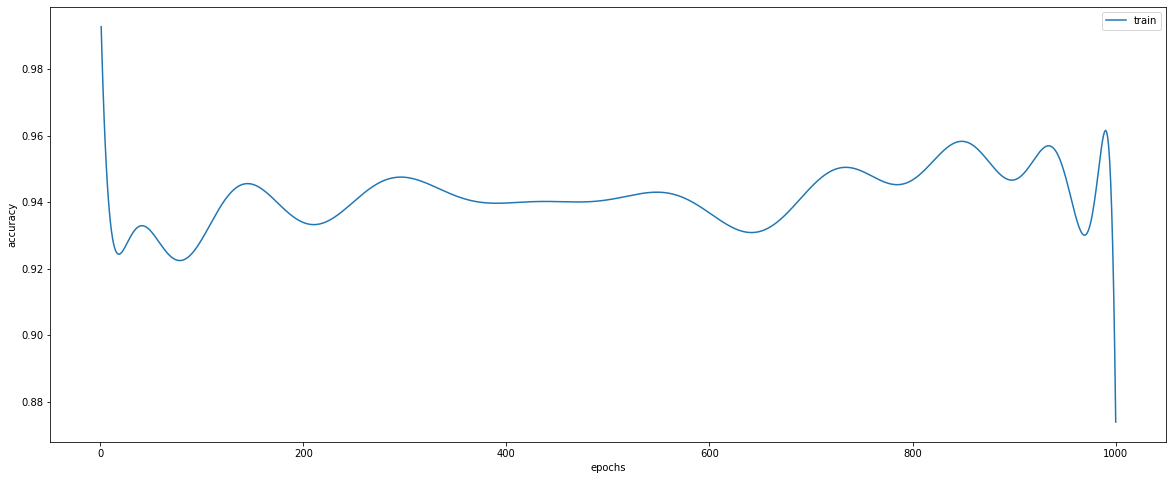

In [105]:
acc = np.polyfit(epoch_l,accuracy_l,25)
poly_y = np.poly1d(acc)(epoch_l)
rcParams["figure.figsize"] = (20,8)
plt.plot(epoch_l,poly_y,label='train')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [106]:
test_img=imgs[0]
test_img=np.expand_dims(test_img,axis=0)


In [107]:
pred=model.predict(test_img)
arr=pred.tolist()
arr_p=[]
for l in arr:
    arr_p.append(l)

In [108]:
m=np.argmax(arr)

In [109]:
m

10

In [110]:
pred[0,m]

0.98520386

In [111]:
model.save('C:/Users/komej/Desktop/birds recognition/birds_rev2/bird3v2.h5')

C:\anaconda3\envs\keras\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [3]:
model=load_model('C:/Users/komej/Desktop/birds recognition/birds_rev2/bird1.h5')